Lexicon-based tools like VADER primarily analyze words individually, relying on predefined sentiment scores for each word or phrase. They do not deeply understand the connections between words or the context of the sentence.

Limitations:

- No nuanced understanding: "Not bad" might be interpreted as negative because "bad" has a negative score, even though the phrase means something positive.
- Lack of contextual relationships: Sentences like "The movie was a hit, unlike the previous flop" may not capture the contrast implied by "unlike."

For deeper contextual understanding, models like BERT are better suited because they use contextual embeddings to analyze the relationships between words.

In [ ]:
from google.colab import drive
import json

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.simplefilter('ignore')

In [ ]:
import os
import pandas as pd
import re
from collections import Counter

In [ ]:
# Define the file path
file_path = '/content/drive/My Drive/Colab Notebooks/NLP_Ignas/nlp_finalproject/'

In [ ]:
%%time

sentences_df = pd.read_csv(os.path.join(file_path, 'sentences.csv'))

# Display the DataFrame
sentences_df.head(2)

CPU times: user 15.2 s, sys: 1.36 s, total: 16.5 s
Wall time: 22.1 s


,article_id,sentence_id,sentence
0,1,1,Observation Simulation And AI Join Forces To R...
1,1,2,CREDIT The Institute of Statistical Mathematic...


In [ ]:
# Make a copy of sentences_df
df = sentences_df.copy()

In [ ]:
df.shape

(6523835, 3)

In [ ]:
from transformers import pipeline

# Load the fine-tuned model from Google Drive
classifier = pipeline(
    'sentiment-analysis',
    model='/content/drive/My Drive/Colab Notebooks/NLP_Ignas/nlp_finalproject/models/financial-distilbert-lg',
    tokenizer='/content/drive/My Drive/Colab Notebooks/NLP_Ignas/nlp_finalproject/models/financial-distilbert-lg',
    device=0,  # Use GPU
    truncation=True  # Truncate sequences longer than 512 tokens
)

In [ ]:
# Test the model
articles = [
    "The company announced record-breaking profits this quarter.",
    "The market crash led to widespread panic among investors.",
    "The new product launch received mixed reviews."
]

results = classifier(articles)

for article, result in zip(articles, results):
    print(f"Article: {article}")
    print(f"Sentiment: {result['label']}, Confidence: {result['score']:.4f}")

Article: The company announced record-breaking profits this quarter.
Sentiment: POSITIVE, Confidence: 0.9697
Article: The market crash led to widespread panic among investors.
Sentiment: NEGATIVE, Confidence: 0.9198
Article: The new product launch received mixed reviews.
Sentiment: NEGATIVE, Confidence: 0.6330


In the BERT method, the confidence score (e.g., sentiment_score_DistilBERT) represents the model's probability or certainty about its predicted sentiment label. While it can loosely be interpreted as the strength of the sentiment, this interpretation depends on how you define "strongness." Let’s break it down:

1. What the Confidence Score Represents:

The score (e.g., 0.9697, 0.9198, 0.6330) is typically the softmax probability for the predicted sentiment label.
If the model predicts "POSITIVE" with a confidence of 0.9697, it means the model assigns a 96.97% likelihood to the sentence being positive.
Similarly, 0.9198 for "NEGATIVE" indicates the model is 91.98% confident in the "NEGATIVE" label.

2. Relation to Sentiment Strength:

- High Confidence (Near 1.0): If the confidence is close to 1.0, you might interpret it as the sentiment being strongly aligned with the predicted label. For example:

"Record-breaking profits" (POSITIVE, 0.9697) suggests very strong positivity.

"Market crash" (NEGATIVE, 0.9198) suggests very strong negativity.

- Lower Confidence (Closer to 0.5): Scores closer to 0.5 might indicate weaker sentiment or ambiguity in the text. For instance:

"Mixed reviews" (NEGATIVE, 0.6330) suggests weaker negativity, as the score is relatively low.

3. Caveats in Interpreting Confidence as Strength:

- Confidence depends on the model: A high confidence score doesn't necessarily mean the sentiment is strongly positive or negative. It only reflects the model's certainty in its prediction.
For example, a score of 0.9 for "NEGATIVE" might not mean the text is very negative but rather that the model is highly confident it belongs to the "NEGATIVE" category.

- Strength is subjective: Sentiment "strength" (e.g., intensity of emotion) is better assessed using lexicons or specialized methods like sentiment intensity analysis (e.g., VADER). BERT doesn't natively assess intensity but rather categorizes the sentiment.

4. Key Insights:

If want to treat the confidence score as a proxy for strength, you can combine it with the sentiment label:

POSITIVE, 0.9697 → Very positive sentiment.

NEGATIVE, 0.6330 → Weak negative sentiment.

In [ ]:
def analyze_sentiment(df, column_name):
    """
    Analyzes the sentiment of sentences in a specified column of a DataFrame.
    Adds two new columns to the DataFrame: 'sentiment_score' and 'sentiment_label'.

    Args:
    df (pd.DataFrame): The DataFrame containing the text to be analyzed.
    column_name (str): The name of the column containing the text.

    Returns:
    pd.DataFrame: The original DataFrame with two new columns for sentiment score and label.
    """
    # Apply sentiment analysis to each row in the specified column
    results = df[column_name].apply(lambda x: classifier(x)[0])

    # Extract sentiment score and label, and add them as new columns to the DataFrame
    df['sentiment_score_DistilBERT'] = results.apply(lambda x: x['score'])
    df['sentiment_labe_DistilBERT'] = results.apply(lambda x: x['label'])

    return df

In [ ]:
sample_df = df.sample(n=100, random_state=42)

In [ ]:
%%time

sample_df = analyze_sentiment(sample_df, 'sentence')

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


CPU times: user 508 ms, sys: 1.45 ms, total: 510 ms
Wall time: 508 ms


In [ ]:
sample_df.head(10)

,article_id,sentence_id,sentence,sentiment_score_DistilBERT,sentiment_labe_DistilBERT
4782671,112776,23,As AI continues to evolve it will undoubtedly ...,0.824930,POSITIVE
5216078,122859,3,A DifferenceMichiganNationalNational PoliticsR...,0.988713,NEUTRAL
3603786,85020,43,It is not written by and does not necessarily ...,0.988327,NEUTRAL
1928759,45464,27,You can try out their service for free no sign...,0.989297,NEUTRAL
3128438,73861,15,Along with contributing significant value to t...,0.523608,POSITIVE
5957979,140375,40,A Cision company.,0.987474,NEUTRAL
657433,15469,13,The key offerings in the report Evaluating the...,0.990205,NEUTRAL
5054843,119080,37,Throughout the conference visitors can visit t...,0.990757,NEUTRAL
5133580,120897,28,By deployment model the market is differentiat...,0.989868,NEUTRAL
6099824,143709,9,How is AI changing cancer diagnostics AI has t...,0.972442,POSITIVE


### Check for rows where the sentence column is null or empty

In [ ]:
# Check for rows where the sentence column is null or empty
invalid_rows = df[df['sentence'].isnull() | (df['sentence'].str.strip() == '')]
print(invalid_rows)

         article_id  sentence_id sentence
1120155       26465            8      NaN
1742207       41063           15      NaN
1776169       41861           15      NaN
1980949       46699           24      NaN
1980950       46699           25      NaN
1980951       46699           26      NaN
2190663       51678            8      NaN
2495904       58894           18      NaN
2800843       66144           68      NaN
2800861       66144           86      NaN
2800876       66144          101      NaN
2800882       66144          107      NaN
2800884       66144          109      NaN
2800889       66144          114      NaN
2800897       66144          122      NaN
2800910       66144          135      NaN
3604805       85038           14      NaN
3865986       91136           10      NaN
3865987       91136           11      NaN
3901232       91952            8      NaN
4049227       95465            9      NaN
4049233       95465           15      NaN
4049239       95465           21  

In [ ]:
# Remove rows with null or empty 'sentence'
df_cleaned = df[df['sentence'].notnull()]  # Remove null values
df_cleaned = df_cleaned[df_cleaned['sentence'].str.strip() != '']  # Remove empty strings

# Verify no invalid rows remain
invalid_rows = df_cleaned[df_cleaned['sentence'].isnull() | (df_cleaned['sentence'].str.strip() == '')]
print(f"Number of invalid rows after cleaning: {len(invalid_rows)}")  # Should print 0

Number of invalid rows after cleaning: 0


### Apply my fine-tuned model to entire dataset df

### Optimized Batch Processing: The pipeline processes multiple sentences in parallel, maximizing GPU usage.

In [ ]:
import time
from datasets import Dataset

# Convert the DataFrame to a Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df_cleaned)

# Define a batch processing function
def analyze_batch(batch):
    results = classifier(batch['sentence'])
    batch['sentiment_score_DistilBERT'] = [res['score'] for res in results]
    batch['sentiment_label_DistilBERT'] = [res['label'] for res in results]
    return batch

# Measure execution time
start_time = time.time()

# Apply the batch function to the Dataset
hf_dataset = hf_dataset.map(analyze_batch, batched=True, batch_size=128, desc="Processing Sentences")  # Adjust batch_size as needed

end_time = time.time()
print(f"Processing time: {end_time - start_time:.2f} seconds")

Processing Sentences:   0%|          | 0/6523802 [00:00<?, ? examples/s]

Processing time: 28434.02 seconds


In [ ]:
# Convert back to a DataFrame
df_cleaned = hf_dataset.to_pandas()

In [ ]:
df_cleaned.head(10)

,article_id,sentence_id,sentence,__index_level_0__,sentiment_score_DistilBERT,sentiment_label_DistilBERT
0,1,1,Observation Simulation And AI Join Forces To R...,0,0.989424,NEUTRAL
1,1,2,CREDIT The Institute of Statistical Mathematic...,1,0.541715,POSITIVE
2,1,3,After extensive training and testing on large ...,2,0.933930,NEUTRAL
3,1,4,This is a powerful new tool for analyzing big ...,3,0.789955,NEUTRAL
4,1,5,Wide area survey data can be used to study the...,4,0.990115,NEUTRAL
5,1,6,In gravitational lensing the gravity of a fore...,5,0.904259,NEUTRAL
6,1,7,Some examples of gravitational lensing are obv...,6,0.987985,NEUTRAL
7,1,8,The large-scale structure consisting mostly of...,7,0.944016,NEUTRAL
8,1,9,Averaging over many galaxies in an area is req...,8,0.989562,NEUTRAL
9,1,10,But this technique of looking at many galaxy i...,9,0.860652,NEUTRAL


In [ ]:
# Save the DataFrame as a CSV file
df_cleaned.to_csv(file_path + 'sentences_with_sentiments.csv', index=False)

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int64  
 1   sentence_id                 int64  
 2   sentence                    object 
 3   __index_level_0__           int64  
 4   sentiment_score_DistilBERT  float64
 5   sentiment_label_DistilBERT  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 298.6+ MB


In [ ]:
df_cleaned.shape

(6523802, 6)

In [ ]:
df_cleaned.tail(10)

,article_id,sentence_id,sentence,__index_level_0__,sentiment_score_DistilBERT,sentiment_label_DistilBERT
6523792,153749,17,For more information on the innovative PolymRi...,6523825,0.989099,NEUTRAL
6523793,153749,18,Matmerize is a leading innovator at the inters...,6523826,0.968439,NEUTRAL
6523794,153749,19,With a mission to revolutionize fire safety an...,6523827,0.828528,POSITIVE
6523795,153749,20,Our dedicated team of experts strives to creat...,6523828,0.698514,POSITIVE
6523796,153749,21,For further information inquiries or media con...,6523829,0.988329,NEUTRAL
6523797,153749,22,E infomatmerize.com Y Watch Matmerize Videos o...,6523830,0.988944,NEUTRAL
6523798,153749,23,our LinkedIn Page GlobeNewswire Distribution I...,6523831,0.988860,NEUTRAL
6523799,153749,24,Copyright 2023 Zambia News Network,6523832,0.983628,NEUTRAL
6523800,153749,25,All rights reserved.,6523833,0.985499,NEUTRAL
6523801,153749,26,General Production Health Protection Governanc...,6523834,0.961057,NEUTRAL


### Verify rows with null or empty values under sentence column are indeed excluded

In [ ]:
# Check if the row exists
row_exists = not df_cleaned[(df_cleaned['article_id'] == 26465) & (df_cleaned['sentence_id'] == 8)].empty

# Print result
if row_exists:
    print("The row with article_id=26465 and sentence_id=8 exists.")
else:
    print("The row with article_id=26465 and sentence_id=8 does NOT exist.")

The row with article_id=26465 and sentence_id=8 does NOT exist.


In [ ]:
# Check if the row exists
row_exists = not df_cleaned[(df_cleaned['article_id'] == 1) & (df_cleaned['sentence_id'] == 1)].empty

# Print result
if row_exists:
    print("exists.")
else:
    print("NOT exist.")

exists.


In [ ]:
# Check if the row exists
row_exists = not df_cleaned[(df_cleaned['article_id'] == 46699) & (df_cleaned['sentence_id'] == 24)].empty

# Print result
if row_exists:
    print("exists.")
else:
    print("NOT exist.")

NOT exist.


### Visualize the count of each sentiment label (e.g., NEUTRAL, POSITIVE, NEGATIVE).

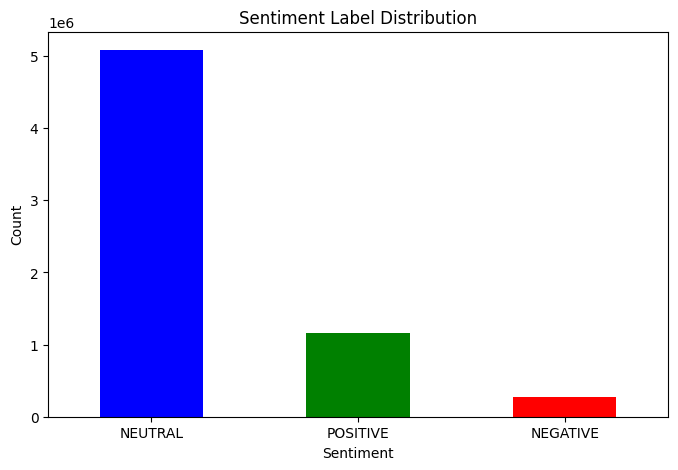

In [ ]:
import matplotlib.pyplot as plt
sentiment_counts = df_cleaned['sentiment_label_DistilBERT'].value_counts()

# Bar Chart
sentiment_counts.plot(kind='bar', color=['blue', 'green', 'red'], figsize=(8, 5))
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Show the range and distribution of sentiment scores.

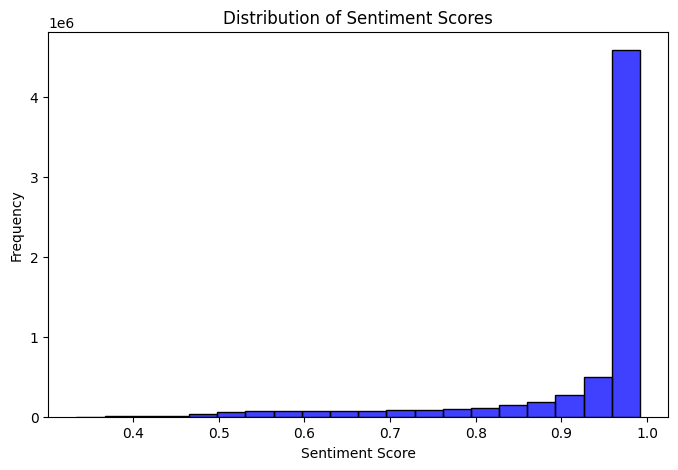

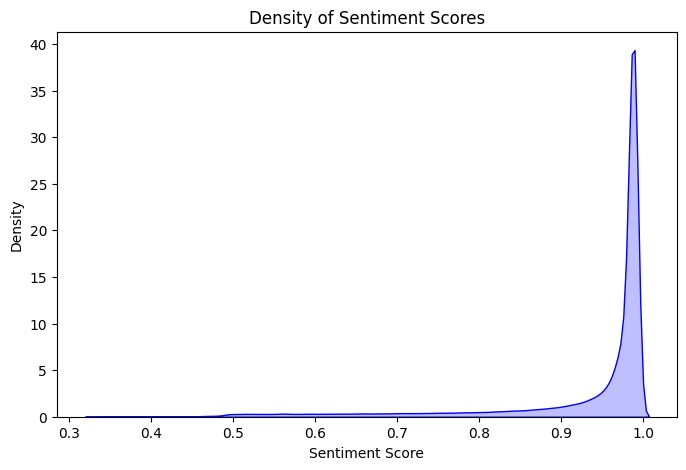

In [ ]:
import seaborn as sns

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['sentiment_score_DistilBERT'], bins=20, kde=False, color='blue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# KDE Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(df_cleaned['sentiment_score_DistilBERT'], shade=True, color='blue')
plt.title('Density of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.show()

### Compare sentiment scores across different labels.

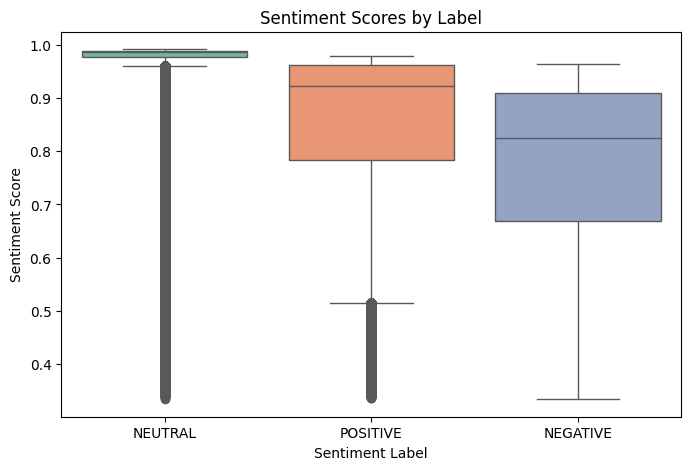

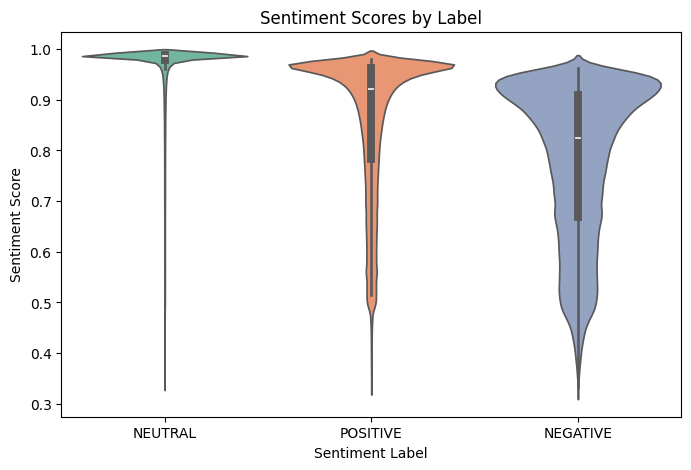

In [ ]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment_label_DistilBERT', y='sentiment_score_DistilBERT', data=df_cleaned, palette='Set2')
plt.title('Sentiment Scores by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()

# Violin Plot
plt.figure(figsize=(8, 5))
sns.violinplot(x='sentiment_label_DistilBERT', y='sentiment_score_DistilBERT', data=df_cleaned, palette='Set2')
plt.title('Sentiment Scores by Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Sentiment Score')
plt.show()

In [ ]:
%%time

test = pd.read_csv(os.path.join(file_path, 'sentences_with_sentiments.csv'))

# Display the DataFrame
test.head(2)

CPU times: user 17 s, sys: 1.85 s, total: 18.8 s
Wall time: 20.9 s


,article_id,sentence_id,sentence,__index_level_0__,sentiment_score_DistilBERT,sentiment_label_DistilBERT
0,1,1,Observation Simulation And AI Join Forces To R...,0,0.989424,NEUTRAL
1,1,2,CREDIT The Institute of Statistical Mathematic...,1,0.541715,POSITIVE


In [ ]:
test.shape

(6523802, 6)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int64  
 1   sentence_id                 int64  
 2   sentence                    object 
 3   __index_level_0__           int64  
 4   sentiment_score_DistilBERT  float64
 5   sentiment_label_DistilBERT  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 298.6+ MB


While higher confidence for NEGATIVE might correlate with stronger negativity in some cases, the confidence score primarily reflects how certain the model is about its classification.

So I will use "sentiment_label_certainty" to tell how certain the sentiment_label_DistilBERT is for a sentence, treating sentiment_label_certainty as a proxy for strength.

- Assign the sentiment_score_DistilBERT as-is for POSITIVE labels.

- Assign 0 for NEUTRAL labels, since they don't contribute strongly to sentiment.

- If there are NEGATIVE labels in your data (even if not in your example), assign a negative version of sentiment_score_DistilBERT.

In [ ]:
# Define a function to calculate the sentiment_label_certainty
def calculate_sentiment_label_certainty(row):
    if row['sentiment_label_DistilBERT'] == 'POSITIVE':
        return row['sentiment_score_DistilBERT']
    elif row['sentiment_label_DistilBERT'] == 'NEGATIVE':
        return -row['sentiment_score_DistilBERT']
    else:  # NEUTRAL
        return 0

# Apply the function to create the sentiment_score column
test['sentiment_label_certainty'] = test.apply(calculate_sentiment_label_certainty, axis=1)

In [ ]:
test.head(20)

,article_id,sentence_id,sentence,__index_level_0__,sentiment_score_DistilBERT,sentiment_label_DistilBERT,sentiment_label_certainty
0,1,1,Observation Simulation And AI Join Forces To R...,0,0.989424,NEUTRAL,0.000000
1,1,2,CREDIT The Institute of Statistical Mathematic...,1,0.541715,POSITIVE,0.541715
2,1,3,After extensive training and testing on large ...,2,0.933930,NEUTRAL,0.000000
3,1,4,This is a powerful new tool for analyzing big ...,3,0.789955,NEUTRAL,0.000000
4,1,5,Wide area survey data can be used to study the...,4,0.990115,NEUTRAL,0.000000
5,1,6,In gravitational lensing the gravity of a fore...,5,0.904259,NEUTRAL,0.000000
6,1,7,Some examples of gravitational lensing are obv...,6,0.987985,NEUTRAL,0.000000
7,1,8,The large-scale structure consisting mostly of...,7,0.944016,NEUTRAL,0.000000
8,1,9,Averaging over many galaxies in an area is req...,8,0.989562,NEUTRAL,0.000000
9,1,10,But this technique of looking at many galaxy i...,9,0.860652,NEUTRAL,0.000000


In [ ]:
test.describe()

,article_id,sentence_id,__index_level_0__,sentiment_score_DistilBERT,sentiment_label_certainty
count,6.523802e+06,6.523802e+06,6.523802e+06,6.523802e+06,6.523802e+06
mean,7.689930e+04,2.641915e+01,3.261915e+06,9.307047e-01,1.202929e-01
std,4.437603e+04,1.979123e+01,1.883271e+06,1.138193e-01,3.822494e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,3.338542e-01,-9.631420e-01
25%,3.843800e+04,1.100000e+01,1.630951e+06,9.416891e-01,0.000000e+00
50%,7.695000e+04,2.200000e+01,3.261916e+06,9.836959e-01,0.000000e+00
75%,1.153300e+05,3.700000e+01,4.892876e+06,9.884683e-01,0.000000e+00
max,1.537490e+05,2.450000e+02,6.523834e+06,9.916066e-01,9.797616e-01


sentiment_label_certainty range is (−0.963142, 0.9797616)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6523802 entries, 0 to 6523801
Data columns (total 7 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int64  
 1   sentence_id                 int64  
 2   sentence                    object 
 3   __index_level_0__           int64  
 4   sentiment_score_DistilBERT  float64
 5   sentiment_label_DistilBERT  object 
 6   sentiment_label_certainty   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 348.4+ MB


In [ ]:
# Save the DataFrame as a CSV file
test.to_csv(file_path + 'sentences_with_sentiments_certainty.csv', index=False)